In [3]:
#- Initial plan - load data, describe feature, feed time series into prompt, ask GPT about mortality (yes or no). Add demographic information
import pandas as pd
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt

path_to_chart_file = '/mnt/c/Users/hhelm/Documents/Helivan/Data/physionet.org/files/mimiciv/2.2/icu/chartevents.csv'
DATAFRAME = pd.read_csv(path_to_chart_file, sep=',', nrows=100000)

path_to_items_file = '/mnt/c/Users/hhelm/Documents/Helivan/Data/physionet.org/files/mimiciv/2.2/icu/d_items.csv'
ITEMS = pd.read_csv(path_to_items_file, sep=',')

rvs_items = list(ITEMS[ITEMS['category'] == 'Routine Vital Signs']['abbreviation'])
rvs_items_to_keep = ['HR', 'ABPm', 'NBPm', 'Temperature C', 'QTc']

subject_ids = np.unique(list(DATAFRAME['subject_id']))
print(f'n unique subjects: {len(subject_ids)}')

stay_ids = np.unique(list(DATAFRAME['stay_id']))
print(f'n unique stays: {len(stay_ids)}')

n unique subjects: 17
n unique stays: 24


In [4]:
def get_values_by_stay_id_given_item_abbreviation(stay_id, item_abbreviation):
    item_id = ITEMS[ITEMS['abbreviation'] == item_abbreviation]['itemid'].to_list()[0]
    
    stay_df = DATAFRAME[DATAFRAME['stay_id'] == stay_id].copy()
    item_stay_df = stay_df[stay_df['itemid'] == item_id].copy()
    
    charttimes = item_stay_df['charttime'].to_list()
    values = item_stay_df['value'].to_list()
    
    return charttimes, values

def get_charttimes_and_values(stay_id, item_list):
    
    return_dict = {}
    
    for item in item_list: 
        return_dict[item]={}
        charttimes, values = get_values_by_stay_id_given_item_abbreviation(stay_id, item)
        
        return_dict[item]['charttimes'] = charttimes
        return_dict[item]['values'] = values
        
    
    return return_dict
    

def plot_values(stay_id_rvs_dict):
    abbreviations = list(stay_id_rvs_dict.keys())
    
    temp_dict = {}
    min_float = 1e10
    
    no_measurement_list = []
    
    for abbr in abbreviations:        
        datetime_objects = [datetime.strptime(charttime, '%Y-%m-%d %H:%M:%S') for charttime in stay_id_rvs_dict[abbr]['charttimes']]
        if len(datetime_objects) == 0:
            no_measurement_list.append(abbr)
            continue
        
        temp_dict[abbr] = {}

        floats = [datetime.timestamp(dto) for dto in datetime_objects]
        temp_min_float = min(floats)
        if temp_min_float < min_float:
            min_float = temp_min_float
        
        argsorts = np.argsort(floats)
        floats = np.sort(floats)
        
        values = stay_id_rvs_dict[abbr]['values']
        values = np.array(values)[argsorts].astype(float)
        
        temp_dict[abbr]['floats'] = floats
        temp_dict[abbr]['values'] = values
        
    
    n_non_zero_measurements = len(abbreviations) - len(no_measurement_list)
    fig, ax = plt.subplots(1,n_non_zero_measurements,figsize=(5*n_non_zero_measurements, 5), sharex=True)

    c=0
    for abbr in abbreviations:
        if abbr in no_measurement_list:
            continue
        
        temp_dict[abbr]['floats'] = [(f - min_float) / 3600 for f in temp_dict[abbr]['floats']]
        
        unitname = list(ITEMS[ITEMS['abbreviation'] == abbr]['unitname'])[0]

        ax[c].plot(temp_dict[abbr]['floats'], temp_dict[abbr]['values'])
        ax[c].set_title(abbr, fontsize=18)
        ax[c].set_ylabel(unitname, fontsize=16)
        ax[c].set_xlabel('Hours since admission', fontsize=16)
        
        ax[c].tick_params(labelsize=14)
        
        c+=1
    plt.tight_layout()

/tmp/ipykernel_509/4252338647.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,n_non_zero_measurements,figsize=(5*n_non_zero_measurements, 5), sharex=True)


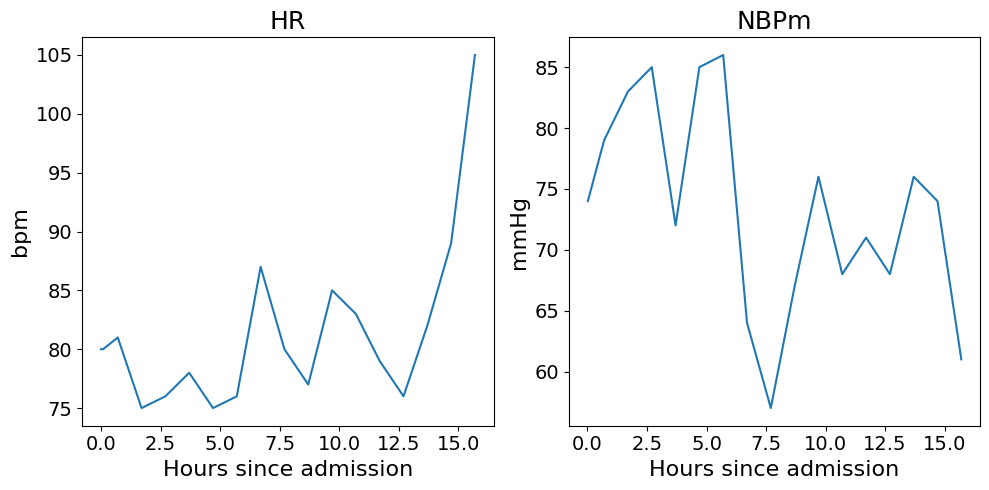

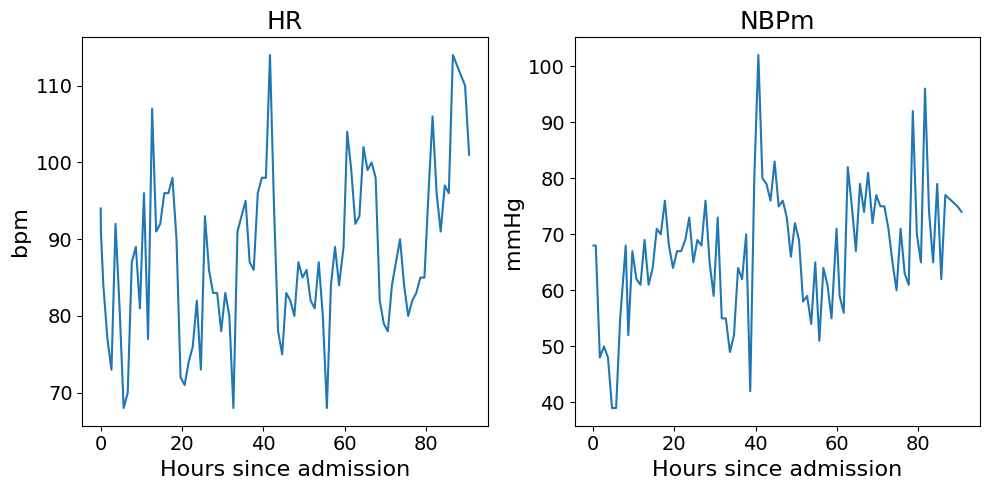

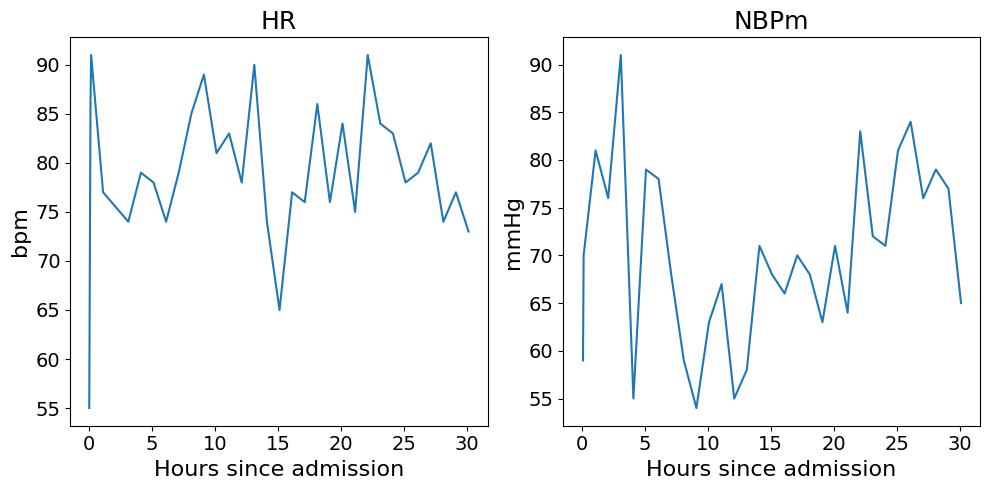

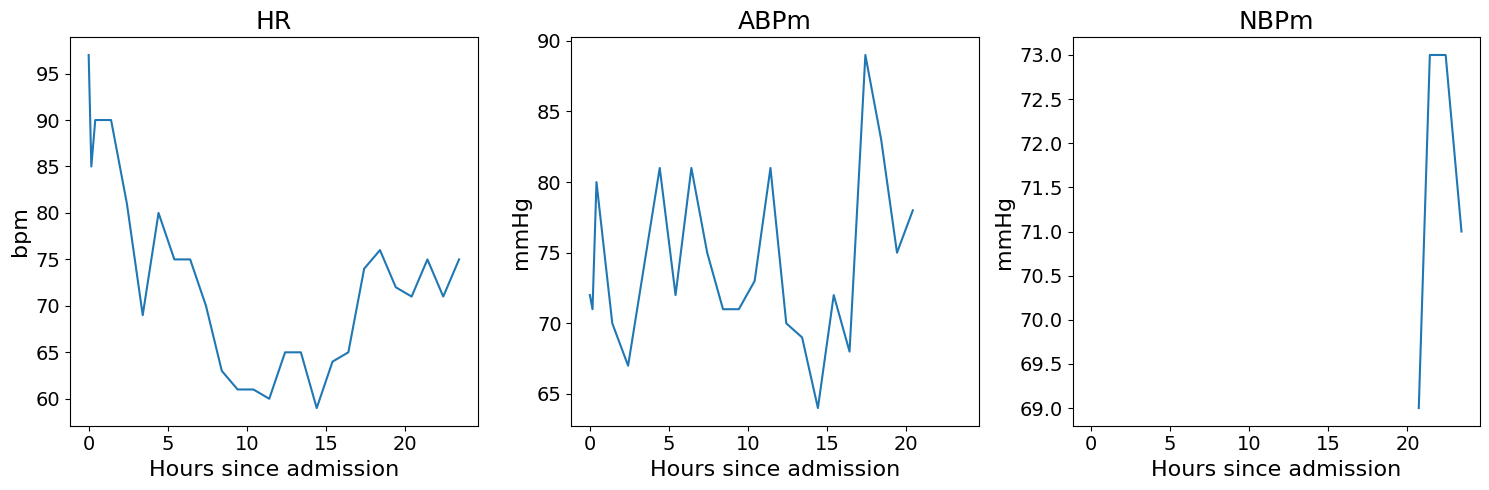

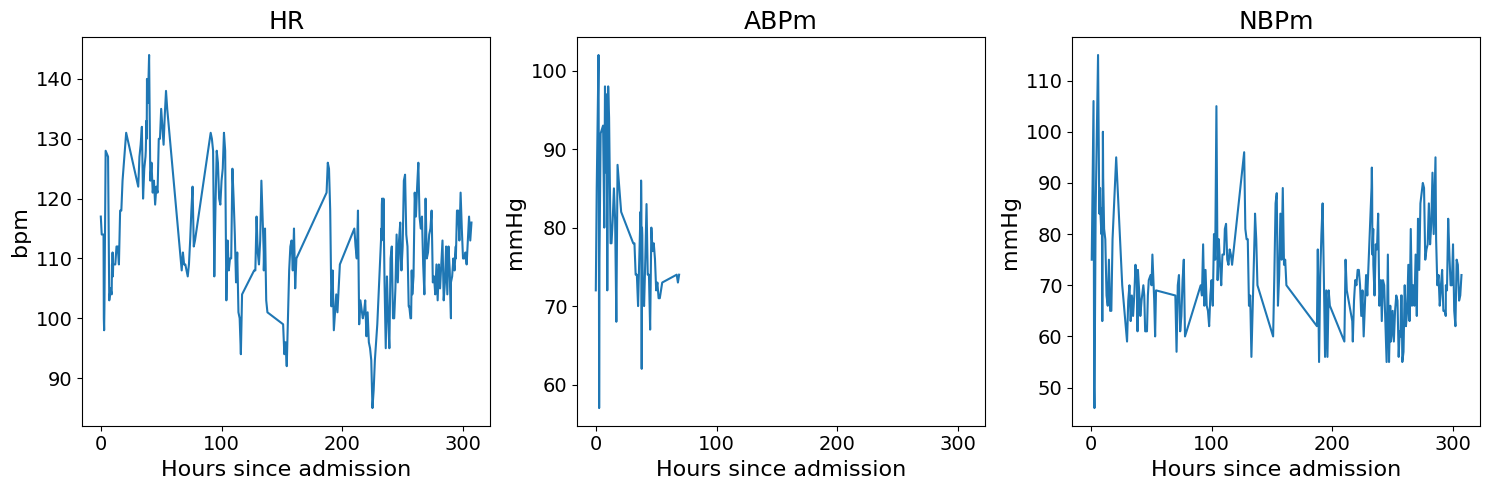

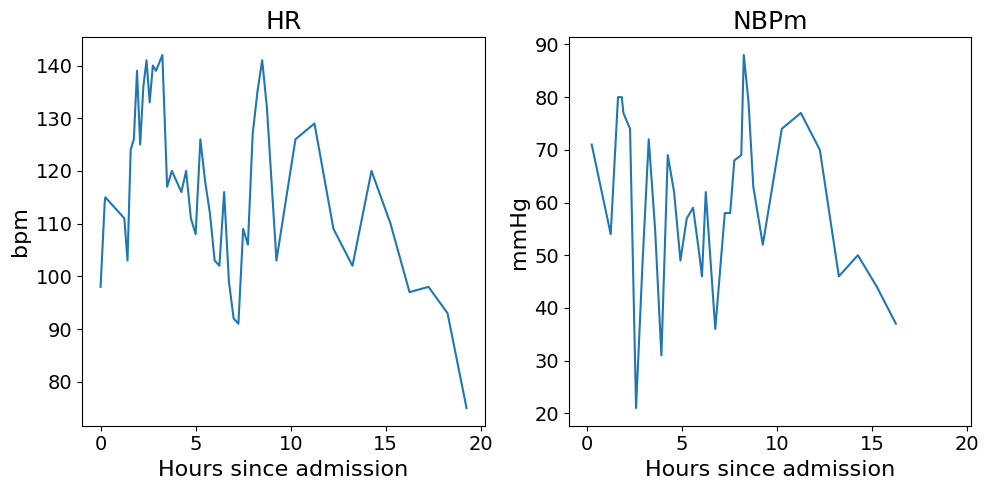

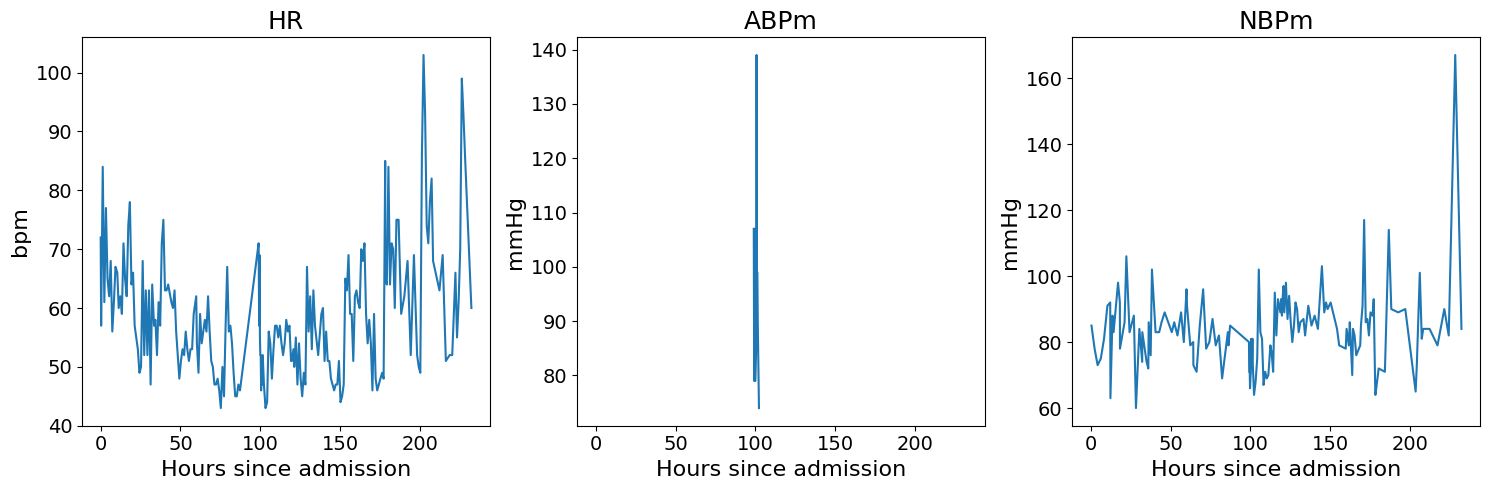

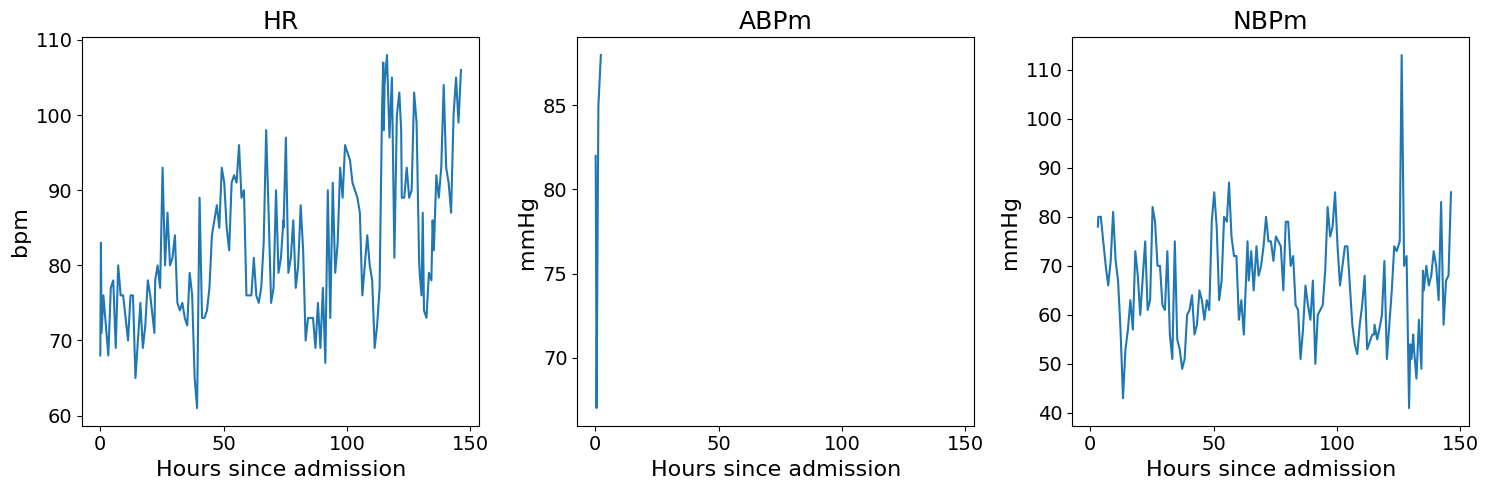

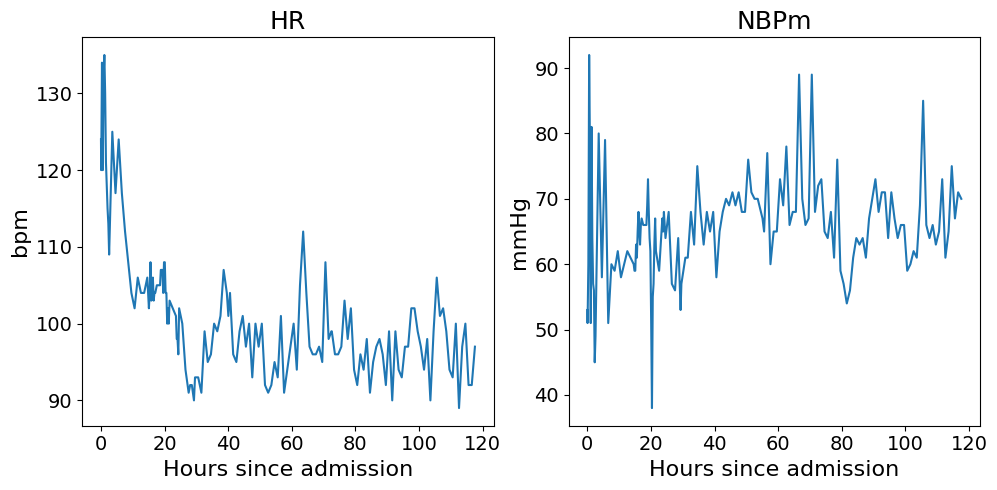

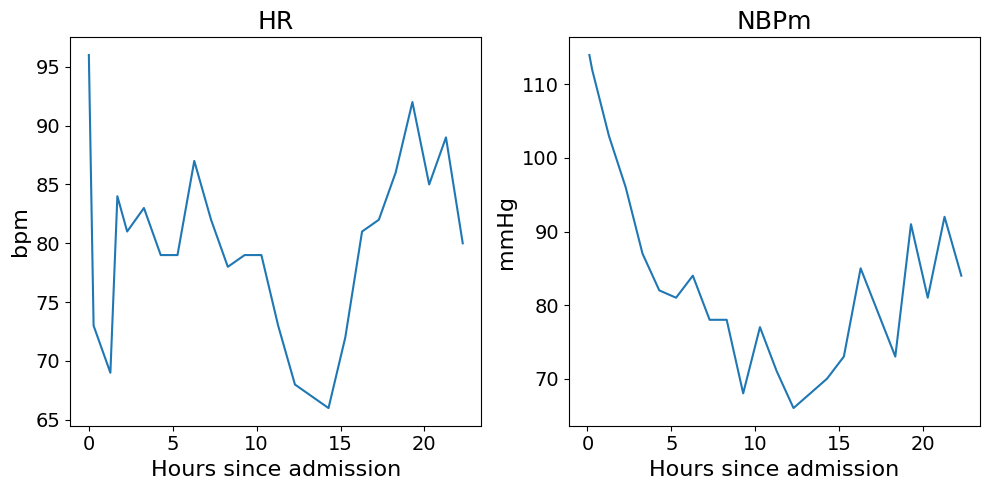

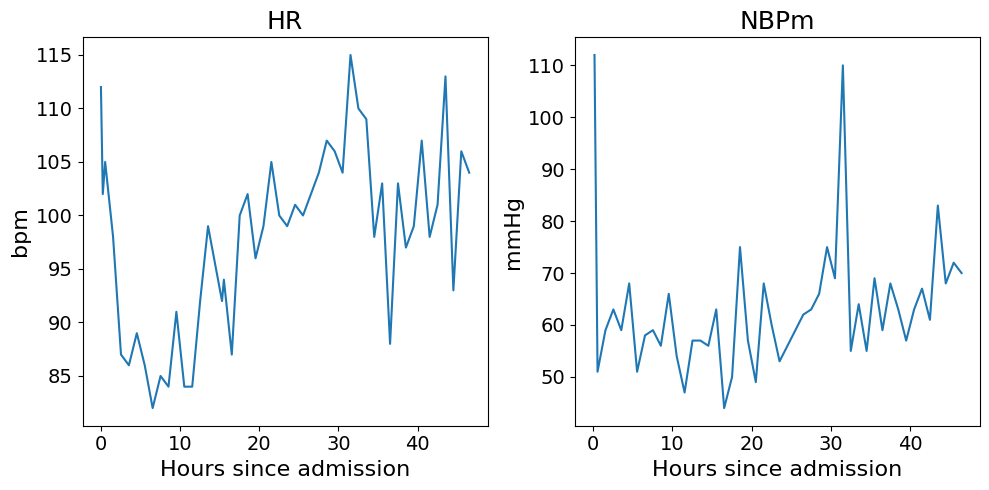

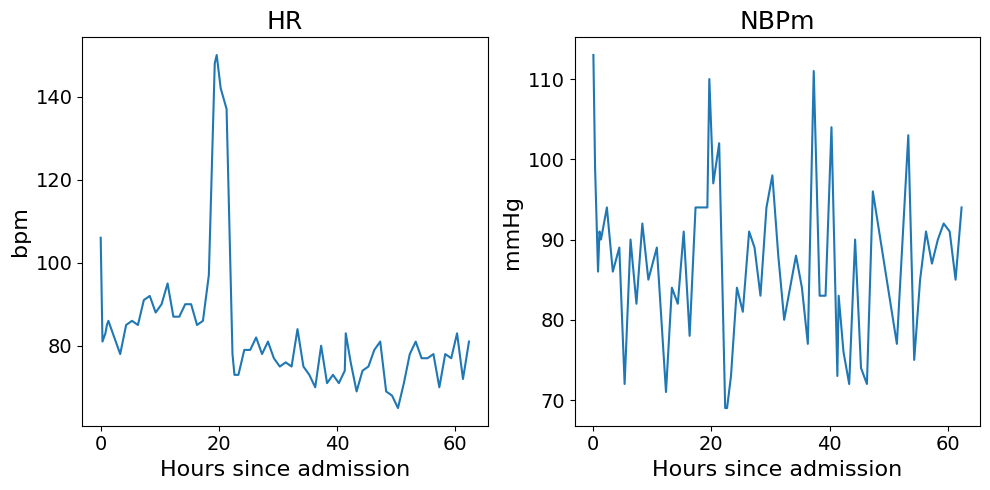

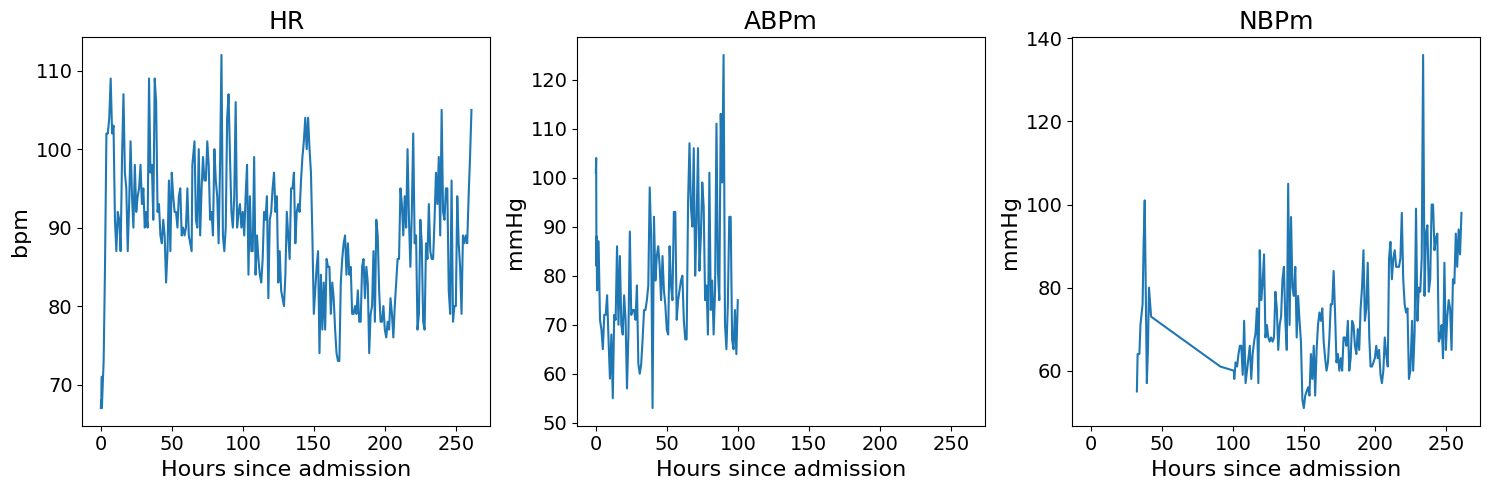

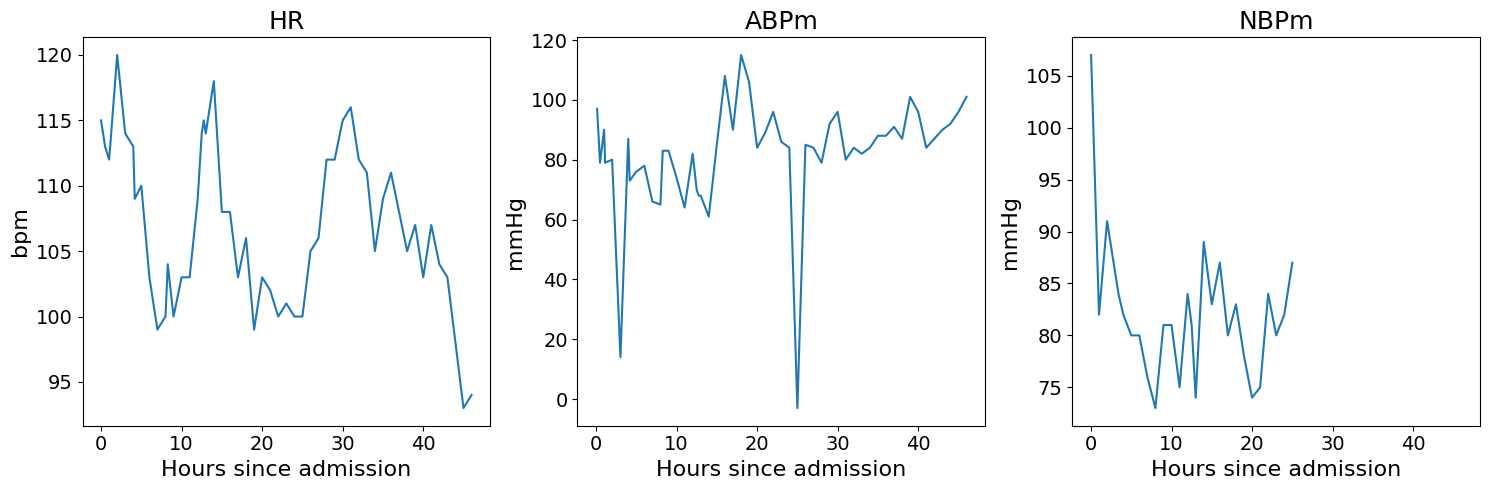

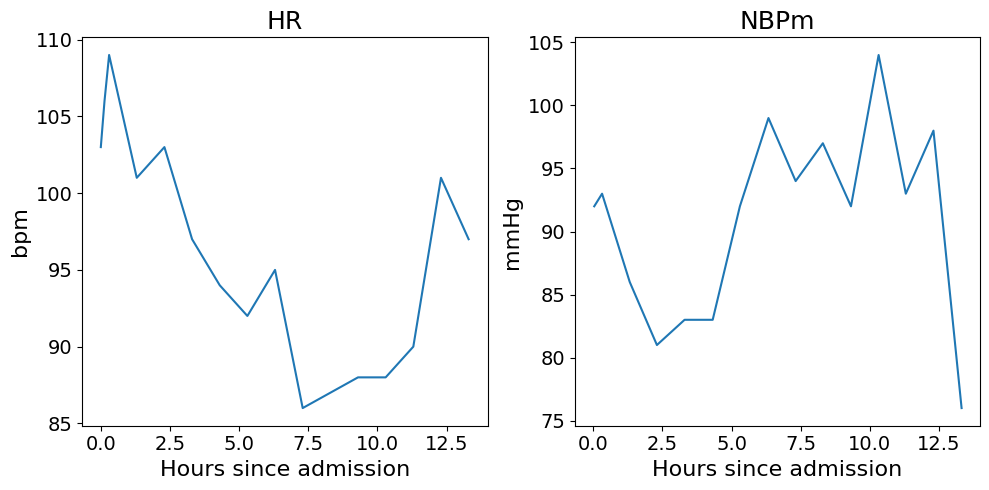

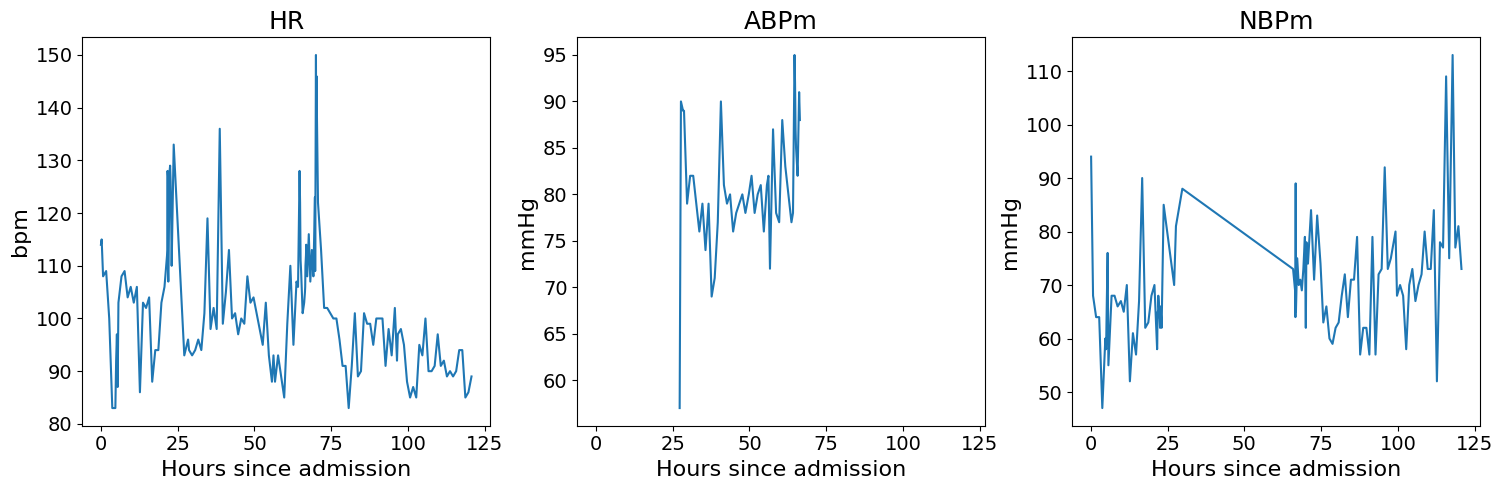

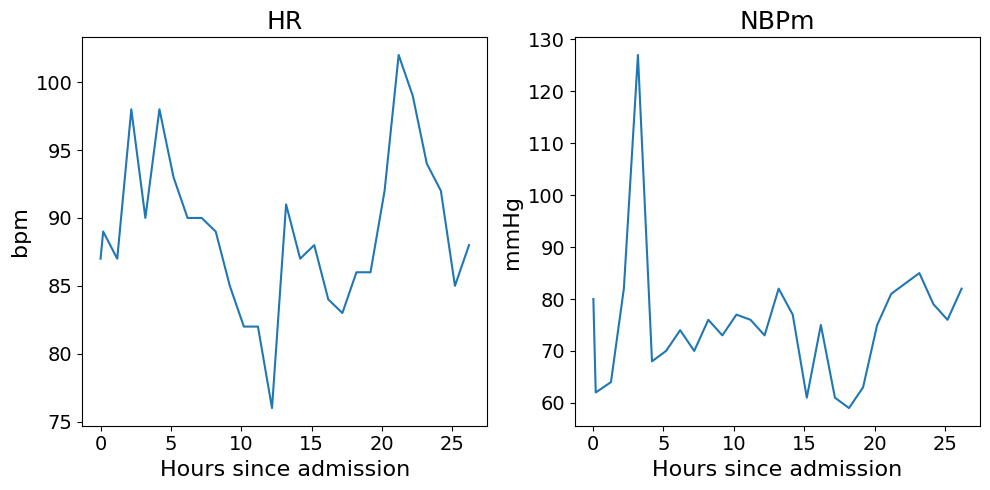

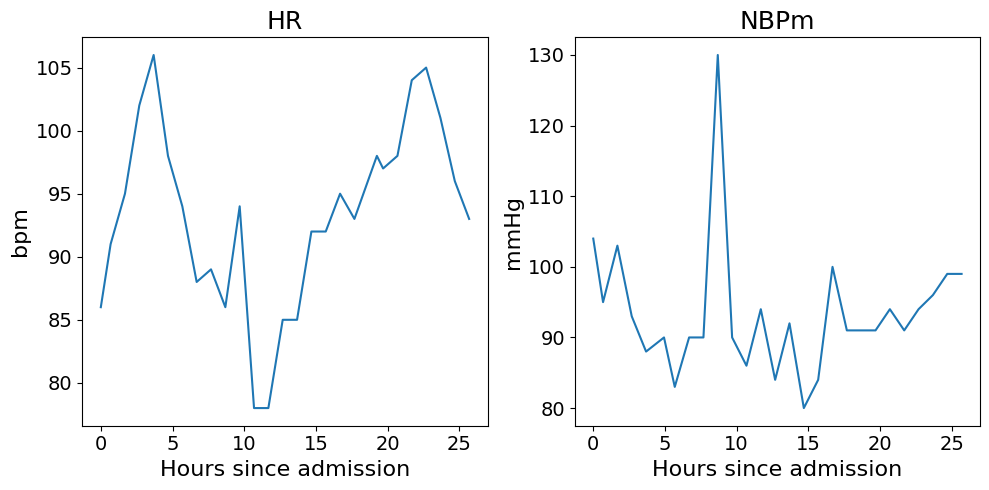

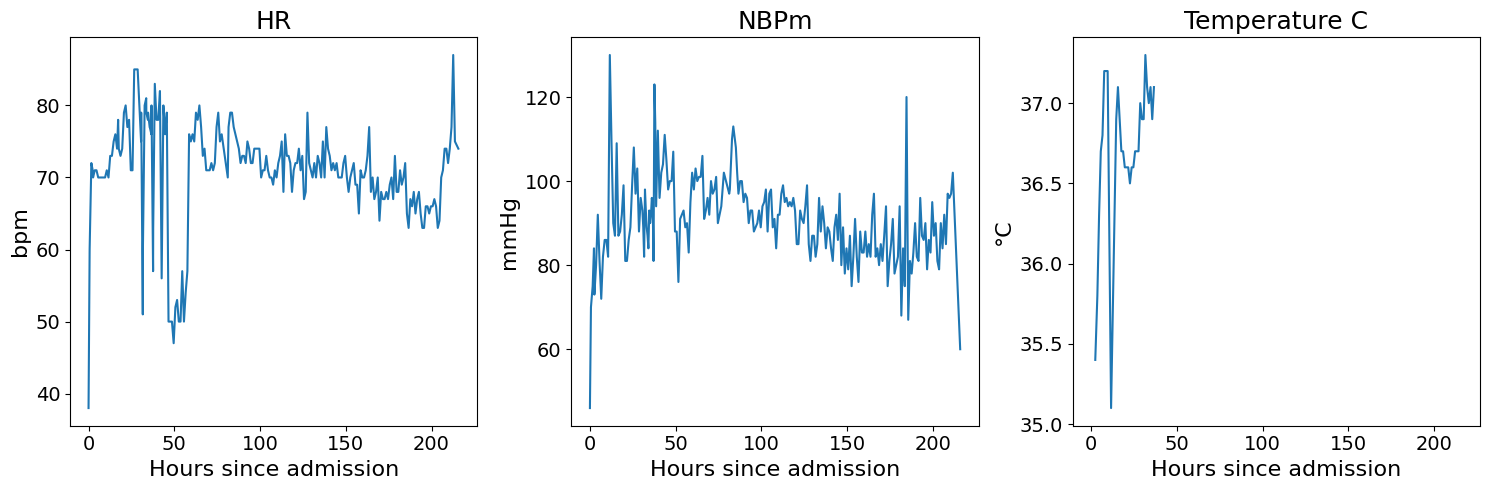

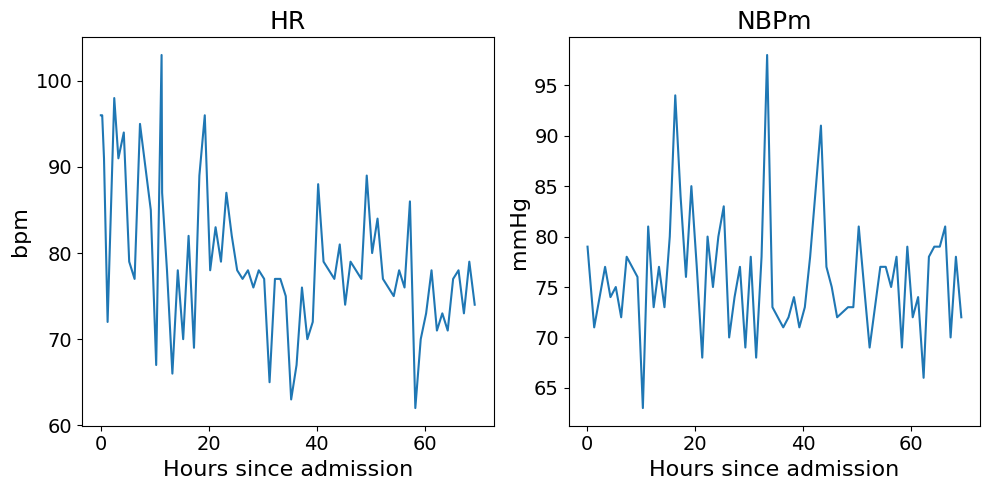

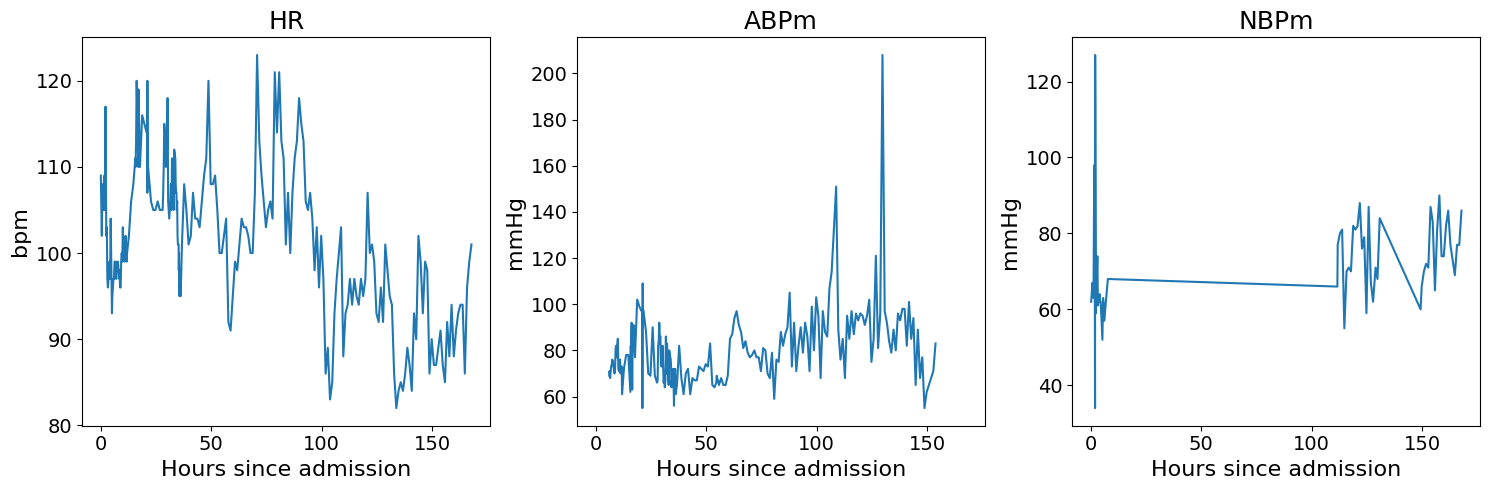

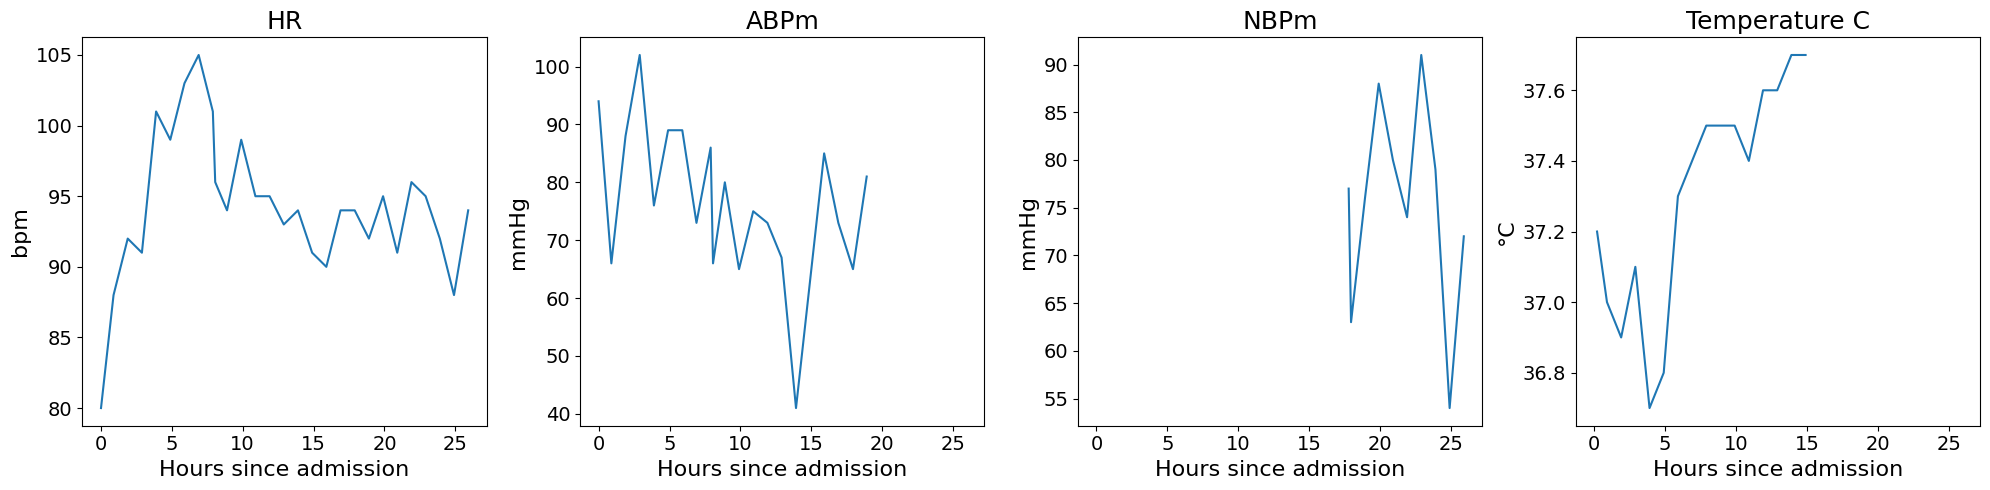

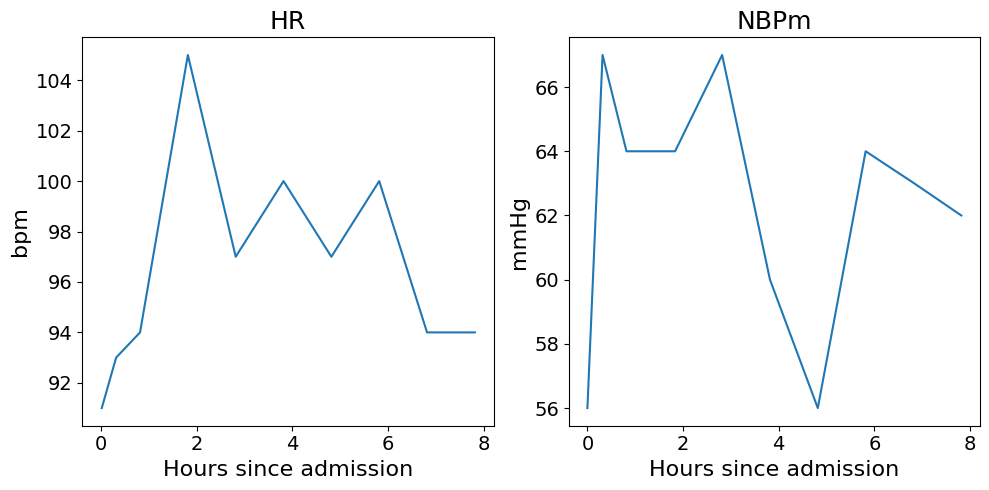

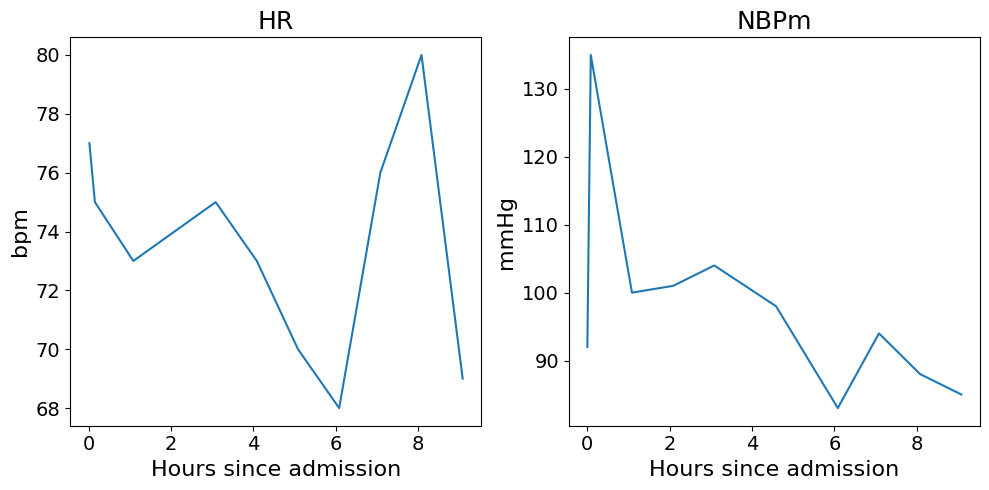

In [5]:
rvs_dict = {}

for stay_id in stay_ids:
    rvs_dict[stay_id] = get_charttimes_and_values(stay_id, rvs_items_to_keep)    
    plot_values(rvs_dict[stay_id])